## **Model Tuning Notebook**

In [1]:
from numba import cuda
import tensorflow as tf

def clear_gpu_memory():
    device = cuda.get_current_device()
    device.reset() # dump the memory contents to free up the memory (it accumulates over the session)
    
# CUDA (Nvidia GPU Computing)
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    
    clear_gpu_memory()
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.set_logical_device_configuration(
    gpus[0], 
    [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # limit to 4GB

    tf.compat.v1.disable_eager_execution()


Num GPUs Available:  1


In [13]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

import os
import sys
sys.path.append('../')

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: /Users/kikobatistaa/Documents/GitHub/Deep-Learning CWD: /Users/kikobatistaa/Documents/GitHub/Deep-Learning


In [14]:
%load_ext autoreload
%autoreload 2

import kerastuner as kt

from src.utils.modeling import *
from src.utils.preproc import *
from src.utils.visualizations import *

from keras.models import Model, Sequential, load_model
from keras.applications import VGG16, InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='binary_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='binary',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=False,
    augmented_images_per_image=5,
    batch_size=32)
print(tuner.oracle.max_trials)

/opt/anaconda3/envs/universidade/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loading and preprocessing data...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kikobatistaa/Documents/GitHub/Deep-Learning/data/train/SOB_B_A-14-22549AB-100-011.png'

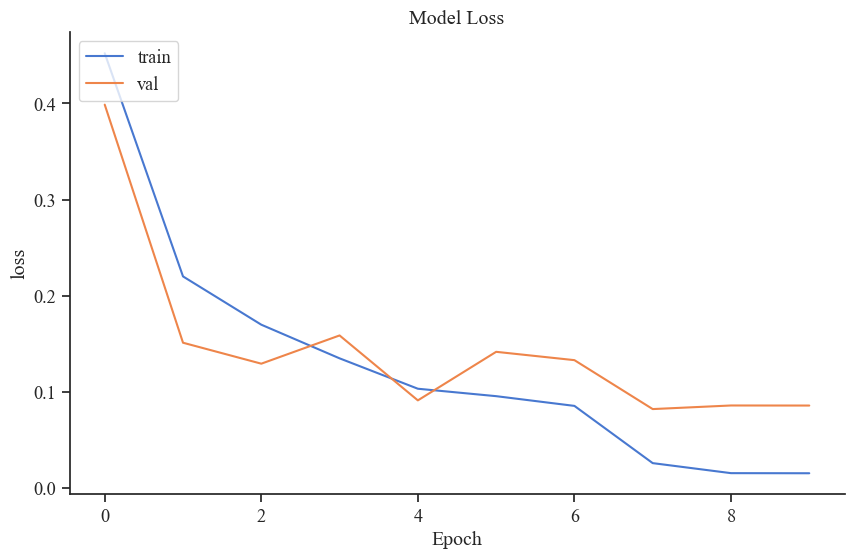

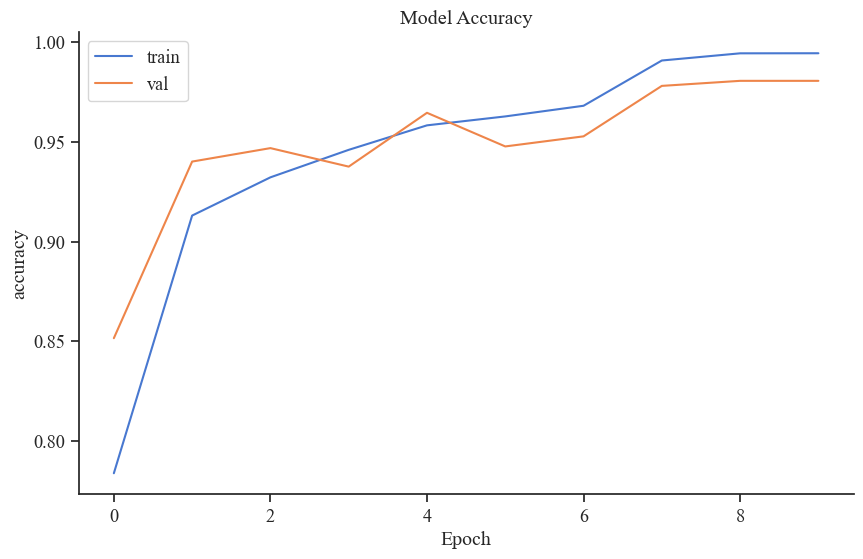

In [10]:
import pickle

# Caminho do arquivo pickle
caminho_arquivo = '/Users/kikobatistaa/Documents/GitHub/Deep-Learning/src/models/VGG16_binary/model_history.pkl'

# Carregar o history
with open(caminho_arquivo, 'rb') as arquivo:
    history = pickle.load(arquivo)

# Plotar a perda (loss) de treinamento e validação
plot_training_history(history, metric='loss', title='Model Loss')

# Plotar a acurácia de treinamento e validação
plot_training_history(history, metric='accuracy', title='Model Accuracy')

In [7]:
import pickle
import numpy as np

# Carregar o histórico salvo no arquivo pickle
caminho_arquivo = '/Users/kikobatistaa/Documents/GitHub/Deep-Learning/src/models/VGG16_binary/model_history.pkl'

with open(caminho_arquivo, 'rb') as file:
    history = pickle.load(file)

# Verificar se há métricas de validação
if 'val_loss' in history:
    val_loss = history['val_loss']
    melhor_epoca = np.argmin(val_loss)
    melhor_val_loss = val_loss[melhor_epoca]
    print(f"Melhor 'val_loss' em época {melhor_epoca + 1}: {melhor_val_loss}")

    # Número total de épocas treinadas
    total_epocas = len(val_loss)
    print(f"Número total de épocas treinadas: {total_epocas}")

    # Comparar com a última época treinada
    if melhor_epoca + 1 < total_epocas:
        print("Os pesos foram provavelmente restaurados da melhor época devido ao 'restore_best_weights=True'.")
    else:
        print("Os pesos finais correspondem à última época treinada.")

else:
    print("Não há métricas de validação disponíveis no histórico.")

Melhor 'val_loss' em época 8: 0.08239644335749051
Número total de épocas treinadas: 10
Os pesos foram provavelmente restaurados da melhor época devido ao 'restore_best_weights=True'.


In [8]:
import pickle

# Carregar o histórico salvo no arquivo pickle
caminho_arquivo = '/Users/kikobatistaa/Documents/GitHub/Deep-Learning/src/models/VGG16_binary/model_history.pkl'

with open(caminho_arquivo, 'rb') as file:
    history = pickle.load(file)

# Imprimir a `val_loss` para cada época
if 'val_loss' in history:
    print("val_loss por época:")
    for i, val in enumerate(history['val_loss']):
        print(f"Época {i + 1}: val_loss = {val}")

    # Identificar a época com a menor `val_loss`
    melhor_epoca = min(range(len(history['val_loss'])), key=lambda i: history['val_loss'][i])
    melhor_val_loss = history['val_loss'][melhor_epoca]

    print(f"\nMelhor 'val_loss' na época {melhor_epoca + 1}: {melhor_val_loss}")

    # Número total de épocas treinadas
    total_epocas = len(history['val_loss'])
    print(f"Número total de épocas treinadas: {total_epocas}")

    # Comparar com a última época treinada
    if melhor_epoca + 1 < total_epocas:
        print("\nOs pesos foram provavelmente restaurados da melhor época devido ao 'restore_best_weights=True'.")
    else:
        print("\nOs pesos finais correspondem à última época treinada.")

else:
    print("Não há métricas de validação ('val_loss') disponíveis no histórico.")

val_loss por época:
Época 1: val_loss = 0.3987618255379953
Época 2: val_loss = 0.15135141457185933
Época 3: val_loss = 0.12957025433685262
Época 4: val_loss = 0.15891088230302175
Época 5: val_loss = 0.09143873382708989
Época 6: val_loss = 0.14189662265366446
Época 7: val_loss = 0.13324318774118038
Época 8: val_loss = 0.08239644335749051
Época 9: val_loss = 0.08613202055108846
Época 10: val_loss = 0.08606210771526285

Melhor 'val_loss' na época 8: 0.08239644335749051
Número total de épocas treinadas: 10

Os pesos foram provavelmente restaurados da melhor época devido ao 'restore_best_weights=True'.


### **Binary Classification Models Fine-Tuning**

#### **Hyperband Model Tuning**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='binary_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='binary',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=False,
    augmented_images_per_image=5,
    batch_size=32
)

tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

#### **Transfer Learning**

**VGG 16**

In [7]:
def binary_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10, learning_rate=0.0001):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

vgg16_binary = binary_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]
    

fitted_vgg16_binary = train_model(train_gen, val_gen, vgg16_binary, callbacks=callbacks, class_weights=class_weights, epochs=10, steps_per_epoch=steps_per_epoch)

Loading and preprocessing data...
Total training images after augmentation: 33198
Class weights computed.
Data generators created.
Epoch 1/10
860/860 [==============================] - ETA: 0s - batch: 429.5000 - size: 31.9826 - loss: 0.4522 - accuracy: 0.7839

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


860/860 [==============================] - 528s 595ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.4522 - accuracy: 0.7839 - val_loss: 0.3988 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 2/10
860/860 [==============================] - 584s 679ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.2203 - accuracy: 0.9131 - val_loss: 0.1514 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 3/10
860/860 [==============================] - 514s 597ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.1701 - accuracy: 0.9322 - val_loss: 0.1296 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 4/10
860/860 [==============================] - 631s 733ms/step - batch: 429.5000 - size: 31.9860 - loss: 0.1352 - accuracy: 0.9460 - val_loss: 0.1589 - val_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 5/10
860/860 [==============================] - 718s 834ms/step - batch: 429.5000 - size: 31.9791 - loss: 0.1035 - accuracy: 0.9583 - val_loss: 0.0914 - val_accuracy: 0.9646 - lr: 1.0000e-04
Epoch 6/10
860/860 [======

In [17]:
save_model(fitted_vgg16_binary, 'src/models/VGG16_binary')
save_training_history(fitted_vgg16_binary, 'src/models/VGG16_binary')

Loading test data...
Loading and preprocessing data...
Total training images (no augmentation): 5533
Class weights computed.
Data generators created.
Starting model evaluation...
Total number of samples in the test generator: 1186


d:\deep_learning_project\src\utils\modeling.py:102: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # select the appropriate class names based on the classification type
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.9848

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.973262 | 0.978495 |   0.975871 |       372 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.990148 | 0.987715 |   0.98893  |       814 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.984823 |
+------------------------+----------+
| Macro Avg Precision    | 0.981705 |
+------------------------+----------+
| Macro Avg Recall       | 0.983105 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.982401 |
+------------------------+----------+
| Weighted Avg Precision | 0.984851 |
+------------------------+----------

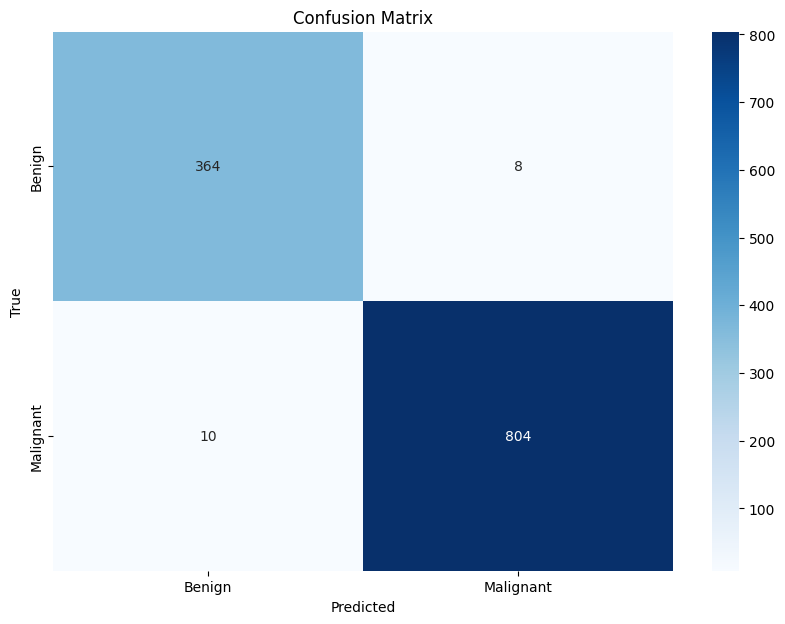

Evaluation complete. Returning results.


{'accuracy': 0.984822934232715,
 'classification_report': {'Benign': {'precision': 0.9732620320855615,
   'recall': 0.978494623655914,
   'f1-score': 0.9758713136729222,
   'support': 372.0},
  'Malignant': {'precision': 0.9901477832512315,
   'recall': 0.9877149877149877,
   'f1-score': 0.988929889298893,
   'support': 814.0},
  'accuracy': 0.984822934232715,
  'macro avg': {'precision': 0.9817049076683966,
   'recall': 0.9831048056854508,
   'f1-score': 0.9824006014859077,
   'support': 1186.0},
  'weighted avg': {'precision': 0.9848514093611562,
   'recall': 0.984822934232715,
   'f1-score': 0.9848339448361096,
   'support': 1186.0}},
 'confusion_matrix': array([[364,   8],
        [ 10, 804]], dtype=int64)}

In [20]:
fitted_vgg16_binary = load_model('src\models\VGG16_binary\saved_model.h5')
evaluate_model(fitted_vgg16_binary, classification_type='binary')

**InceptionV3**

In [4]:
def binary_classification_inceptionv3_model(input_shape=(224, 224, 3), trainable_layers=200, learning_rate=0.0001):
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1024, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)

inceptionv3_binary = binary_classification_inceptionv3_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]
    

fitted_inceptionv3_binary = train_model(train_gen, val_gen, inceptionv3_binary, callbacks=callbacks, class_weights=class_weights, epochs=40, steps_per_epoch=steps_per_epoch)

### **Multiclass Classification Models Fine-Tuning**

#### **Hyperband Model Tuning**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

tuner = kt.Hyperband(
    keras_tuning_model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=2,
    directory='hyperband_logs',
    project_name='multiclass_breast_cancer_cnn',
)

train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(
    image_resolution=(224, 224),
    classification_type='multiclass',
    csv_path='image_metadata/updated_image_data.csv',
    use_data_augmentation=True,
    augmented_images_per_image=5,
    batch_size=32
)
tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

#### **Transfer Learning**

**VGG 16**

In [4]:
def multiclass_classification_vgg16_model(input_shape=(224, 224, 3), trainable_layers=10):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)
                                                    
vgg16_multiclass = multiclass_classification_vgg16_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

fitted_vgg16_multiclass = train_model(train_gen, val_gen, vgg16_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=30, steps_per_epoch=steps_per_epoch)

Loading and preprocessing data...
Total training images after augmentation: 33198
Class weights computed.
Data generators created.
Epoch 1/30
860/860 [==============================] - ETA: 0s - batch: 429.5000 - size: 31.9826 - loss: 2.0480 - accuracy: 0.1137

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


860/860 [==============================] - 666s 729ms/step - batch: 429.5000 - size: 31.9826 - loss: 2.0480 - accuracy: 0.1137 - val_loss: 1.9335 - val_accuracy: 0.1838 - lr: 1.0000e-04
Epoch 2/30
860/860 [==============================] - 653s 759ms/step - batch: 429.5000 - size: 31.9826 - loss: 1.5247 - accuracy: 0.3980 - val_loss: 1.4442 - val_accuracy: 0.4654 - lr: 1.0000e-04
Epoch 3/30
860/860 [==============================] - 723s 839ms/step - batch: 429.5000 - size: 31.9826 - loss: 1.0652 - accuracy: 0.5498 - val_loss: 1.0377 - val_accuracy: 0.6046 - lr: 1.0000e-04
Epoch 4/30
860/860 [==============================] - 705s 819ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.7697 - accuracy: 0.6502 - val_loss: 0.8138 - val_accuracy: 0.6880 - lr: 1.0000e-04
Epoch 5/30
860/860 [==============================] - 664s 771ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.5918 - accuracy: 0.7218 - val_loss: 0.7032 - val_accuracy: 0.7285 - lr: 1.0000e-04
Epoch 6/30
860/860 [======

In [10]:
save_model(fitted_vgg16_multiclass, 'src/models/VGG16_mutlticlass')
save_training_history(fitted_vgg16_multiclass, 'src/models/VGG16_multiclass')

INFO:tensorflow:Assets written to: ram://af12a1f1-eec7-491e-9610-320a8c49c155/assets


INFO:tensorflow:Assets written to: ram://af12a1f1-eec7-491e-9610-320a8c49c155/assets


In [ ]:
fitted_vgg16_multiclass = load_model('src\models\VGG16_multiclass\saved_model.h5')
evaluate_model(fitted_vgg16_multiclass, classification_type='multiclass')

**InceptionV3**

In [6]:
def multiclass_classification_inceptionv3_model(input_shape=(224, 224, 3), trainable_layers=200, learning_rate=0.0001):
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
train_gen, val_gen, test_gen, class_weights, steps_per_epoch = preproc_pipeline(image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=5,
                                                    batch_size=32)
                                                    
inceptionv3_multiclass = multiclass_classification_inceptionv3_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stopping]

fitted_inceptionv3_multiclass = train_model(train_gen, val_gen, inceptionv3_multiclass, callbacks=callbacks, class_weights=class_weights, epochs=40, steps_per_epoch=steps_per_epoch)

Loading and preprocessing data...
Total training images after augmentation: 33198
Class weights computed.
Data generators created.
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/40
860/860 [==============================] - ETA: 0s - batch: 429.5000 - size: 31.9826 - loss: 0.8121 - accuracy: 0.6382

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


860/860 [==============================] - 455s 507ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.8121 - accuracy: 0.6382 - val_loss: 0.5017 - val_accuracy: 0.8196 - lr: 1.0000e-04
Epoch 2/40
860/860 [==============================] - 461s 521ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.2934 - accuracy: 0.8484 - val_loss: 0.6756 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 3/40
860/860 [==============================] - 457s 516ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.1834 - accuracy: 0.9025 - val_loss: 0.5954 - val_accuracy: 0.8373 - lr: 1.0000e-04
Epoch 4/40
860/860 [==============================] - 458s 517ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.1498 - accuracy: 0.9169 - val_loss: 0.5097 - val_accuracy: 0.8491 - lr: 1.0000e-04
Epoch 5/40
860/860 [==============================] - 458s 517ms/step - batch: 429.5000 - size: 31.9826 - loss: 0.0754 - accuracy: 0.9501 - val_loss: 0.3517 - val_accuracy: 0.8988 - lr: 1.0000e-05
Epoch 6/40
860/860 [======